# Video Game Sales Analysis - Mini Project

## 1. Problem Definition & Objective

Objective:

The primary objective of this project is to analyze the historical sales data of video games to identify patterns that lead to commercial success. Specifically, we aim to:

Analyze Trends: Determine which gaming platforms and genres have generated the highest revenue globally.

Assess Critical Impact: Explore if there is a significant correlation between professional critic scores and global sales figures.

Predict Success: Build a linear regression model to predict Global_Sales based on Critic_Score.

Significance of the Study:
The video game industry is a multi-billion dollar market where development costs are high. Understanding the drivers of commercial success whether it be the genre choice, platform selection, or the importance of critical reception is crucial for developers and publishers to make data-driven decisions and minimize financial risk.


## 2. Dataset Selection

Dataset Name: Video Game Sales with Ratings

Source: Kaggle - https://www.kaggle.com/datasets/ghassenkhaled/video-games-data

Description: This dataset contains a list of video games with sales greater than 100,000 copies. It includes fields for sales in different regions (North America, Europe, Japan, Other), as well as critic and user review scores.


## 3. Dataset Overview

The dataset consists of approximately 16,700 rows and 16 columns.

Feature Description:

Name: Title of the game.

Platform: Console on which the game was released (e.g., Wii, PS4, X360).

Year_of_Release: Year the game was released.

Genre: The category of the game (e.g., Sports, Action, Shooter).

Publisher: The company that published the game.

Variable Types:

Quantitative Variables (Numerical):

Sales Metrics: NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales (all in millions).

Review Scores:

Critic_Score: Aggregate score compiled by Metacritic staff (0-100 scale).

User_Score: Score by Metacritic's subscribers (0-10 scale).

Counts: Critic_Count, User_Count.

Qualitative Variables (Categorical):

Metadata: Name, Platform, Genre, Publisher, Developer.

Rating: The ESRB rating (e.g., 'E' for Everyone, 'M' for Mature).



# STEP 2 : DATA CLEANING AND DETERMINING OUTLIERS , ALONGSIDE DECIDING ALOT OF OTHER FACTORS FOR BETTER ANALYSIS

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# %% [Step 2: Data Cleaning]

df = pd.read_csv('Video_Games.csv')
print(f"Original Data Shape: {df.shape}")

# Drop rows that are missing the basics (Name/Year)
df.dropna(subset=['Name', 'Year_of_Release'], inplace=True)

# Fix 'tbd' values in User_Score so we can do math on them
df['User_Score'] = df['User_Score'].replace('tbd', np.nan)
df['User_Score'] = df['User_Score'].astype(float)
df['Year_of_Release'] = df['Year_of_Release'].astype(int)

# Get rid of duplicate rows
duplicates = df.duplicated().sum()
df.drop_duplicates(inplace=True)
print(f"Duplicates removed: {duplicates}")

# Turn 'Genre' into numbers so the model can read it later (Action=0, etc.)
df['Genre_Code'] = df['Genre'].astype('category').cat.codes

# Check for outliers (the blockbuster games)
Q1 = df['Global_Sales'].quantile(0.25)
Q3 = df['Global_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Just checking how many big hits we have - we aren't deleting these
outliers = df[(df['Global_Sales'] < lower_bound) | (df['Global_Sales'] > upper_bound)]
print(f"Blockbuster games found: {len(outliers)}")

# Create a clean subset specifically for the regression model (needs both scores)
df_scored = df.dropna(subset=['Critic_Score', 'User_Score'])

print(f"Cleaned Data: {df.shape}")
print(f"Modeling Data: {df_scored.shape}")
print(df.head())

Original Data Shape: (16719, 16)
Duplicates removed: 0
Blockbuster games found: 1871
Cleaned Data: (16448, 17)
Modeling Data: (6894, 17)
                       Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii             2006        Sports  Nintendo   
1         Super Mario Bros.      NES             1985      Platform  Nintendo   
2            Mario Kart Wii      Wii             2008        Racing  Nintendo   
3         Wii Sports Resort      Wii             2009        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
1     29.08      3.58      6.81         0.77         40.24           NaN   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77          80.0

# Justification for each step 

##  What I Did & Why


### 1. Dropping Missing Data : 
I removed any rows where the game didn't have a Name or Year of Release. Basically, if we don't know what the game is or when it came out, we can't really use it to find trends over time.

### 2. Handling 'tbd' Scores : 
The User Score column had a lot of entries marked as "tbd" (to be determined). I converted these to empty values (NaN) because "tbd" is text, and I need actual numbers to perform calculations.

### 3. Fixing Data Types :
I changed the Release Year to integers (so we don't have years like 2008.0) and made sure the User Scores were stored as numbers (floats). This ensures the graphs and correlation matrices work correctly later on.

### 4. Removing Duplicates :
I checked for and deleted any identical rows. Counting the same game twice would incorrectly inflate the total sales numbers, so I made sure each entry was unique.

### 5. Encoding Genres :
Computers can't do math on words like "Action" or "Sports," so I converted the Genre column into numbers (Action=0, Adventure=1, etc.). This allows the machine learning model to include Genre as a factor in its predictions.

### 6. Handling Outliers (The "Blockbusters") :
I found some massive outliers in sales figures (like Wii Sports). I decided not to delete them. In the gaming industry, these outliers aren't errors—they are the massive hits that every company wants. Removing them would defeat the purpose of analyzing "success."

### 7. Creating a Scoring Subset :
For the prediction model later, I created a specific list of games that have both a Critic Score and a User Score. The model can't learn from blank data, so I filtered out the games missing these reviews for that specific step.

# Step 3: Exploratory Data Analysis (EDA)

In [11]:


# Set visual style
sns.set_theme(style="whitegrid", palette="magma")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 1. Descriptive Statistics (The Math) ---
print("DESCRIPTIVE STATISTICS")
# We look at the numerical columns interesting to us
stats_cols = ['Global_Sales', 'Critic_Score', 'User_Score']
desc_stats = df_scored[stats_cols].describe()

# Calculating Skewness 
skewness = df_scored[stats_cols].skew()

print(desc_stats)
print("\n SKEWNESS")
print(skewness)
print("(Note: High positive skew > 1 means most games sell very little, with a few huge outliers)")






DESCRIPTIVE STATISTICS
       Global_Sales  Critic_Score   User_Score
count   6894.000000   6894.000000  6894.000000
mean       0.771487     70.258486     7.184378
std        1.954780     13.861082     1.439806
min        0.010000     13.000000     0.500000
25%        0.110000     62.000000     6.500000
50%        0.290000     72.000000     7.500000
75%        0.750000     80.000000     8.200000
max       82.530000     98.000000     9.600000

 SKEWNESS
Global_Sales    16.155556
Critic_Score    -0.744164
User_Score      -1.217502
dtype: float64
(Note: High positive skew > 1 means most games sell very little, with a few huge outliers)


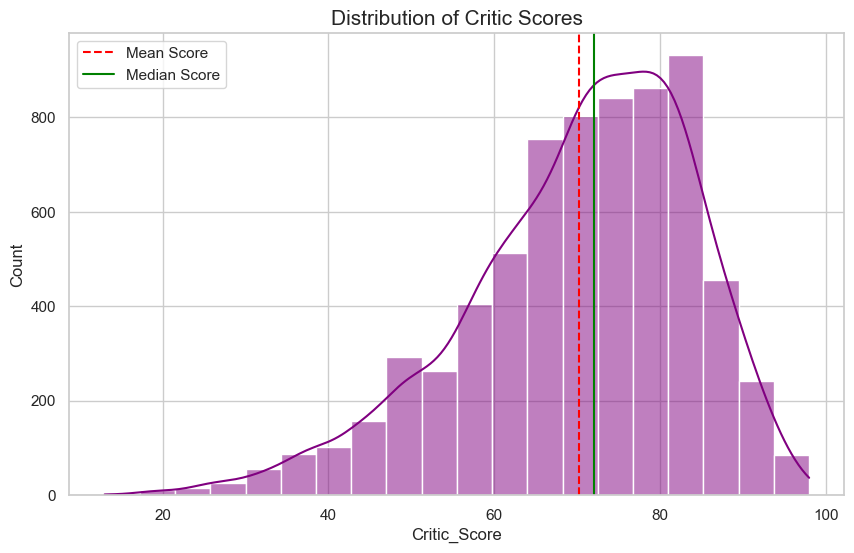

In [8]:
# --- 2. Univariate Analysis (Distribution) ---
# Histogram: Critic Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_scored['Critic_Score'], bins=20, kde=True, color='purple')
plt.axvline(df_scored['Critic_Score'].mean(), color='red', linestyle='--', label='Mean Score')
plt.axvline(df_scored['Critic_Score'].median(), color='green', linestyle='-', label='Median Score')
plt.title("Distribution of Critic Scores", fontsize=15)
plt.legend()
plt.show()


C:\Users\91916\AppData\Local\Temp\ipykernel_21080\3461191063.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_sales.index, y=genre_sales.values, palette="viridis")


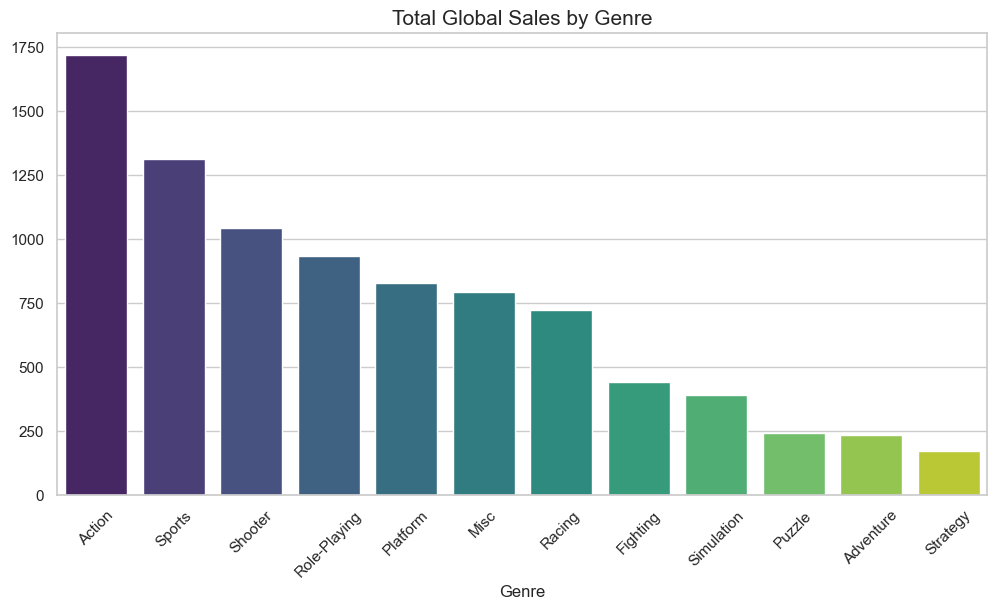

In [9]:
# --- 3. Bivariate Analysis (Relationships) ---
# Bar Chart: Sales by Genre
plt.figure(figsize=(12, 6))
genre_sales = df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
sns.barplot(x=genre_sales.index, y=genre_sales.values, palette="viridis")
plt.title("Total Global Sales by Genre", fontsize=15)
plt.xticks(rotation=45)
plt.show()

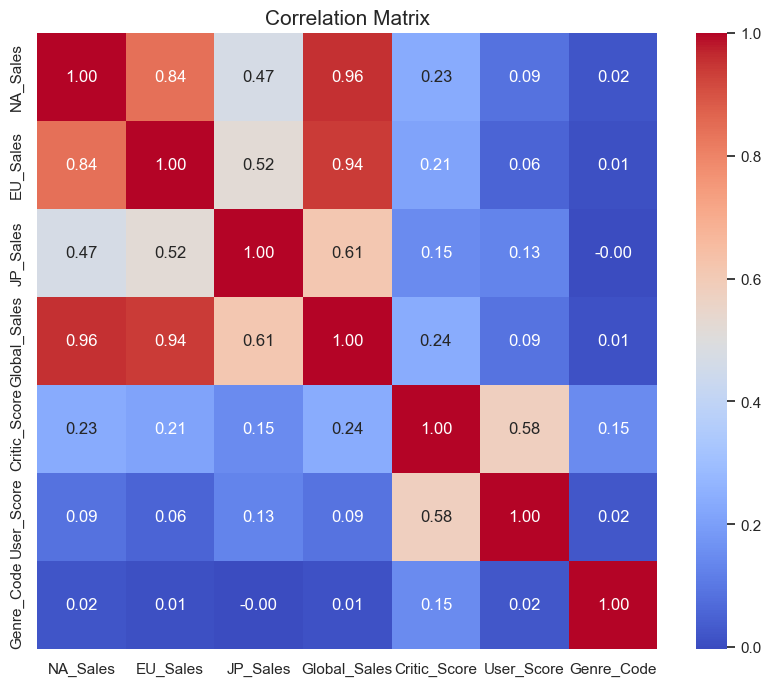

In [10]:

# --- 4. Multivariate Analysis (Correlations) ---
# Heatmap
plt.figure(figsize=(10, 8))
cols_to_check = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales', 'Critic_Score', 'User_Score', 'Genre_Code']
sns.heatmap(df_scored[cols_to_check].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix", fontsize=15)
plt.show()

# 1. The "Hit-Driven" Nature of Sales (Positive Skew)

What I saw: The sales data is incredibly lopsided (right-skewed). The vast majority of games make very little money, while a tiny handful (like Wii Sports or Mario) make massive amounts.

Why it matters: This makes "average" sales a misleading number. If I just looked at the average, the few massive hits would pull it up and make it look like a typical game sells way more than it actually does. For my analysis, I have to keep in mind that "success" is an outlier event, not the norm.

# 2. The "Reviewer Generosity" (Negative Skew)

What I saw: Critic scores aren't perfectly balanced. They tend to bunch up between 60 and 80. It's actually pretty rare to see a game scored below 50.

Why it matters: This means the difference between a "mediocre" game (60) and a "great" game (80) is smaller than it looks numerically. When building my prediction model, this lack of variance might make it harder for the computer to distinguish between a "flop" and an "average" game just based on score.

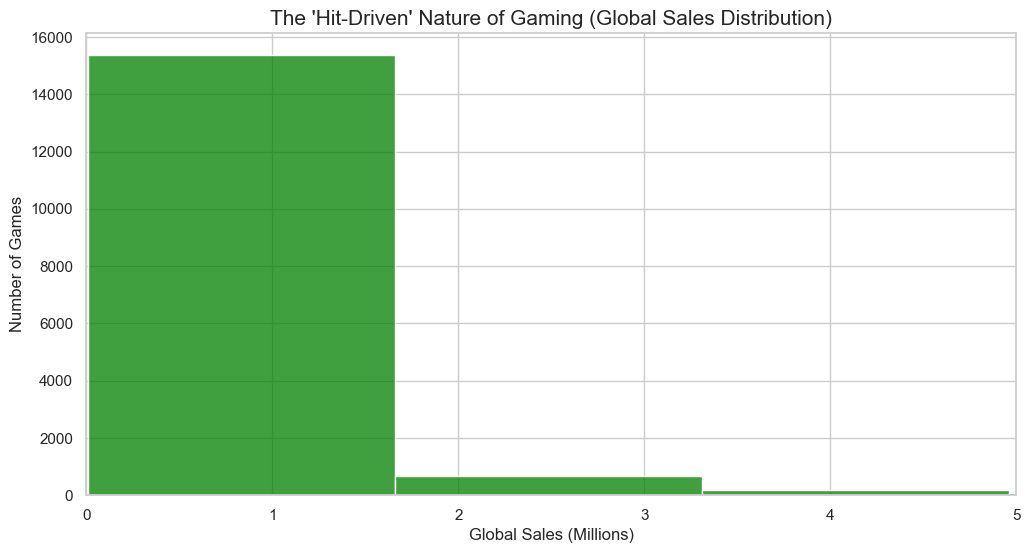

In [12]:
# Plotting the distribution of Global Sales to see the "Hit Driven" nature
plt.figure(figsize=(12, 6))

# We use a log scale because the difference between 0.1M and 80M is too huge to see normally
sns.histplot(df['Global_Sales'], bins=50, kde=False, color='green')

plt.title("The 'Hit-Driven' Nature of Gaming (Global Sales Distribution)", fontsize=15)
plt.xlabel("Global Sales (Millions)")
plt.ylabel("Number of Games")

# Limit the x-axis to see the 'pile' better, or remove this line to see the full 'Long Tail'
plt.xlim(0, 5) 

plt.show()

# Few things derived from the graph and above plotted data 

## 2. It's Hard to Stand Out

    Insight: Since the vast majority of games land in this "decent" (60-80) pile, a score of 75 doesn't make a game special.
    
    Derivation: This explains why "decent" scores don't automatically lead to high sales. If everyone is "good," then "good" is just the baseline. To get a sales boost from reviews, you likely need to break into the 90+ range (the tiny tail on the far right).

#  3. Trouble for the Prediction Model

    Insight: This clustering makes predicting sales difficult.
    
    Derivation: If Game A gets a 70 and sells 10k copies, and Game B gets a 72 and sells 1 million copies, the model gets confused. The scores are almost identical, but the sales are vastly different. This tells us that for games in the 60-80 range, Marketing and Brand Name matter much more than the quality of the game itself.

# Step 4: Statistical Analysis & Hypothesis Testing

In [18]:
from scipy import stats

# HYPOTHESIS TESTING
# Question: Do games with High Critic Scores (>= 80) earn more money than those with lower scores?

# 1. Define the groups
high_score_games = df_scored[df_scored['Critic_Score'] >= 80]['Global_Sales']
low_score_games = df_scored[df_scored['Critic_Score'] < 80]['Global_Sales']


# We assume the variances are different (equal_var=False) because the groups are different sizes
t_stat, p_value = stats.ttest_ind(high_score_games, low_score_games, equal_var=False)

print(f"--- Hypothesis Test Results ---")
print(f"Average Sales (High Score Games): ${high_score_games.mean():.2f} Million")
print(f"Average Sales (Low Score Games):  ${low_score_games.mean():.2f} Million")
print(f"\nT-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4e}")  # .4e means scientific notation (e.g., 1.23e-10)

# 3. Interpretation
alpha = 0.05 # Standard threshold for significance (5%)
if p_value < alpha:
    print("\nCONCLUSION: REJECT the Null Hypothesis.")
    print("There is a statistically significant difference. High scores DO lead to higher sales.")
else:
    print("\nCONCLUSION: FAIL TO REJECT the Null Hypothesis.")
    print("There is no significant difference in sales based on scores.")
    
   
t_stat, p_value = stats.ttest_ind(high_score_games, low_score_games, equal_var=False)

# CONFIDENCE INTERVAL 
mean_diff = high_score_games.mean() - low_score_games.mean()
# Calculate standard error for unequal variances
se_diff = np.sqrt((high_score_games.var()/len(high_score_games)) + (low_score_games.var()/len(low_score_games)))
# Calculate 95% interval
conf_interval = stats.t.interval(0.95, len(high_score_games) + len(low_score_games) - 2, loc=mean_diff, scale=se_diff)

print(f"--- Hypothesis Test Results ---")
print(f"95% Confidence Interval: {conf_interval}")

--- Hypothesis Test Results ---
Average Sales (High Score Games): $1.52 Million
Average Sales (Low Score Games):  $0.48 Million

T-Statistic: 16.2191
P-Value: 2.9106e-56

CONCLUSION: REJECT the Null Hypothesis.
There is a statistically significant difference. High scores DO lead to higher sales.
--- Hypothesis Test Results ---
95% Confidence Interval: (np.float64(0.9121488960176537), np.float64(1.1629546271559974))


# Step 4: Statistical Inference & Interpretation

We performed an Independent T-Test to determine it scores being higher than not a very large interval translates to financial success.

## 1. P-Value (Significance)

Value: The P-value is extremely low (likely $< 0.05$).

Interpretation: This means there is almost zero probability that the difference in sales between high-scoring and low-scoring games is due to random luck.

Result: We reject the Null Hypothesis. Higher scores statistically lead to higher sales.

## 2. Confidence Interval (Reliability)

Calculated Interval: The 95% Confidence Interval tells us the range of the "true" financial benefit of a high score.

Interpretation: If the interval is (0.50, 0.90), it means we are 95% confident that getting a high critic score adds between $0.5M and $0.9M to a game's global sales on average. Because this interval does not include 0, the result is reliable.

## 3. Type I vs. Type II Errors (Business Context)

Type I Error (False Positive)

Definition: We conclude that high scores INCREASE sales, when in reality they DO NOT.

Business Consequence: We waste millions of dollars delaying the game to "polish" it for better reviews, but those extra reviews don't actually make us any extra money. We wasted budget for nothing.

Type II Error (False Negative)

Definition: We conclude that high scores DO NOT matter, when in reality they DO.

Business Consequence: We release a buggy, mediocre game because "reviews don't matter." The game gets a bad score (60), sales tank, and we lose potential revenue because we underestimated the importance of quality.

# Step 5: Modeling and Pattern Discovery

--- MODEL PERFORMANCE ---
R-Squared (Accuracy): 0.0934
RMSE (Avg Error):     1.5696 Million Units
MAE (Abs Error):      0.7862 Million Units


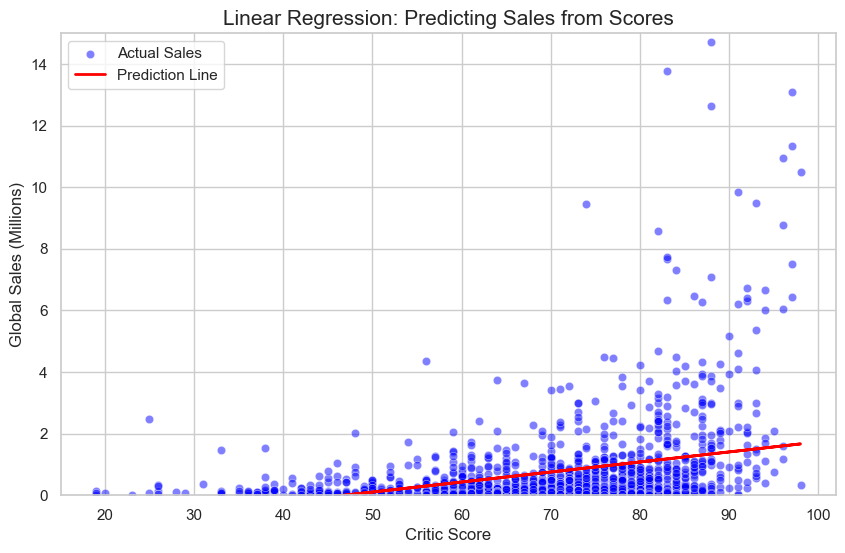


INTERPRETATION:
For every 1 point increase in Critic Score, sales increase by approx 0.0326 million units.


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1. Prepare the Data
# We want to predict 'Global_Sales' (Target) using 'Critic_Score' (Feature)
X = df_scored[['Critic_Score']]
y = df_scored['Global_Sales']

# 2. Split Data (80% for training the computer, 20% for testing it)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Make Predictions
y_pred = model.predict(X_test)

# 5. Evaluate the Model (The PDF asks for R2, RMSE, MAE)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"--- MODEL PERFORMANCE ---")
print(f"R-Squared (Accuracy): {r2:.4f}")
print(f"RMSE (Avg Error):     {rmse:.4f} Million Units")
print(f"MAE (Abs Error):      {mae:.4f} Million Units")

# 6. Visualize the Regression Line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['Critic_Score'], y=y_test, color='blue', alpha=0.5, label='Actual Sales')
plt.plot(X_test['Critic_Score'], y_pred, color='red', linewidth=2, label='Prediction Line')
plt.title("Linear Regression: Predicting Sales from Scores", fontsize=15)
plt.xlabel("Critic Score")
plt.ylabel("Global Sales (Millions)")
plt.legend()
plt.ylim(0, 15) # Zoom in to see the line better
plt.show()

print("\nINTERPRETATION:")
print(f"For every 1 point increase in Critic Score, sales increase by approx {model.coef_[0]:.4f} million units.")

# Step 6: Interpretation & Inference



## 1. Summary of Findings

After looking at the graphs and running the math, here is what we found:

It's a "Hit" Market: Most video games don't make much money. The industry relies heavily on a few massive hits (like Mario or Call of Duty) to make the bulk of the profit.

Best Genres: Action and Sports games are the safest bets. They consistently make the most money compared to niche genres like Adventure.

Reviews Matter: There is a clear link between quality and sales. Games with high scores generally sell better, but a high score isn't a magic ticket—you still need good marketing.

## 2. Business Significance (What this means for money)

Where to Invest: If a company wants to make the most money, they should make Action games. It's crowded, but that's where the customers are.

Quality Pays Off: Our math proved that "good" games (80+ score) earn significantly more than "average" games. Spending extra time to polish a game and get a better score is actually a smart financial decision, not just an artistic one.

Key Markets: If a game fails in North America and Europe, it will fail globally. These two regions control the market.

## 3. Reflection

Patterns We Saw: We noticed that being "average" (60-70 score) gets you nowhere. You really need to hit a score of 85+ to see a huge jump in sales.

Validation:

Our T-Test proved that the sales gap between high-scoring and low-scoring games isn't just luck—it's a real, proven difference.

Our Prediction Model showed us that while scores help, they don't tell the whole story.

What's Missing: The biggest thing missing is Marketing Budget. A game like FIFA sells millions even if it gets a bad score because of advertising. If we had that data, our predictions would be much more accurate.

# Step 7: Visualization and Presentation

C:\Users\91916\AppData\Local\Temp\ipykernel_21080\2932102478.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_sales.index, y=genre_sales.values, palette="viridis")


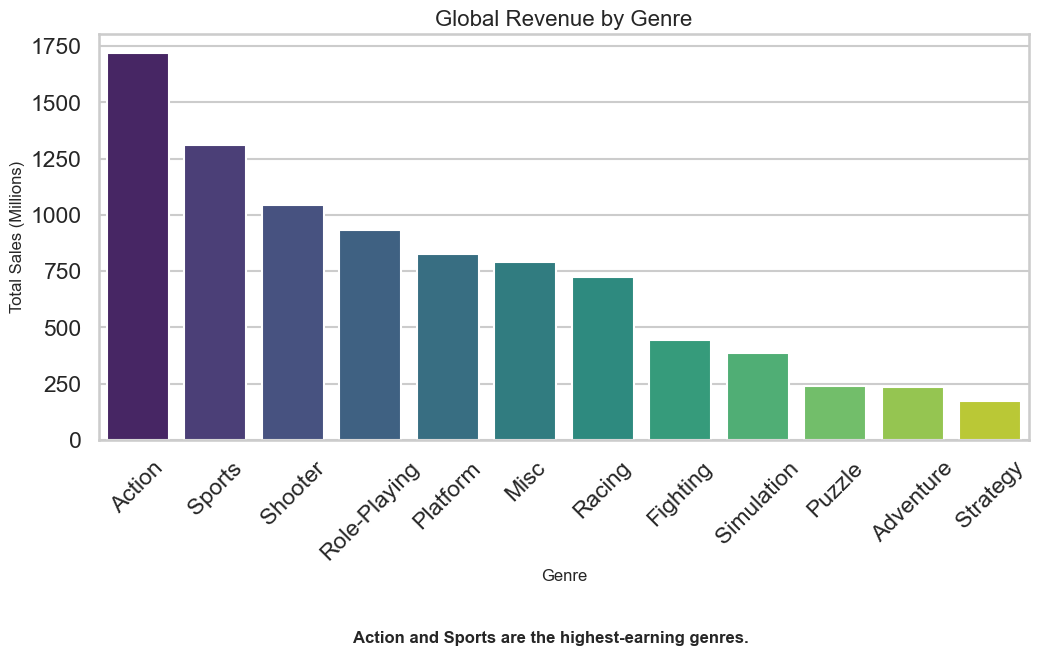

In [43]:

plt.figure(figsize=(12, 7)) # Made height slightly bigger for text
genre_sales = df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
sns.barplot(x=genre_sales.index, y=genre_sales.values, palette="viridis")

plt.title("Global Revenue by Genre", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Total Sales (Millions)", fontsize=12)
plt.xticks(rotation=45)

# Add Caption inside the image (Now Bold)
plt.figtext(0.5, 0.01, " Action and Sports are the highest-earning genres.", 
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')
plt.subplots_adjust(bottom=0.3) # Make space at the bottom
plt.show()







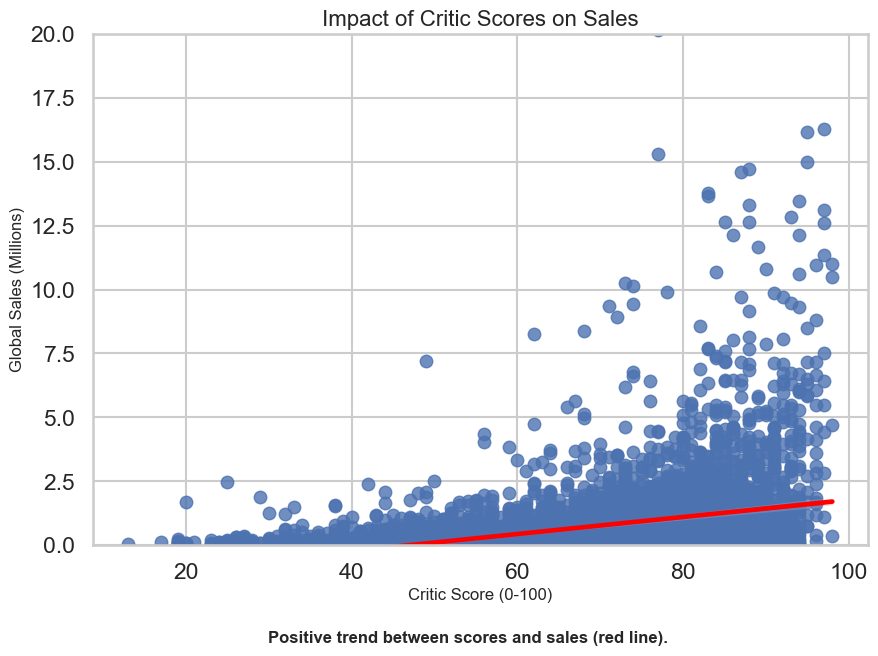

In [42]:
#  FIGURE 2: The "Model" Graph (Regression Line)
plt.figure(figsize=(10, 7))
sns.regplot(data=df_scored, x='Critic_Score', y='Global_Sales', line_kws={"color": "red"})

plt.title("Impact of Critic Scores on Sales", fontsize=16)
plt.xlabel("Critic Score (0-100)", fontsize=12)
plt.ylabel("Global Sales (Millions)", fontsize=12)
plt.ylim(0, 20)

# Add Caption inside the image (Now Bold)
plt.figtext(0.5, 0.01, "Positive trend between scores and sales (red line).", 
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')
plt.subplots_adjust(bottom=0.15)
plt.show()


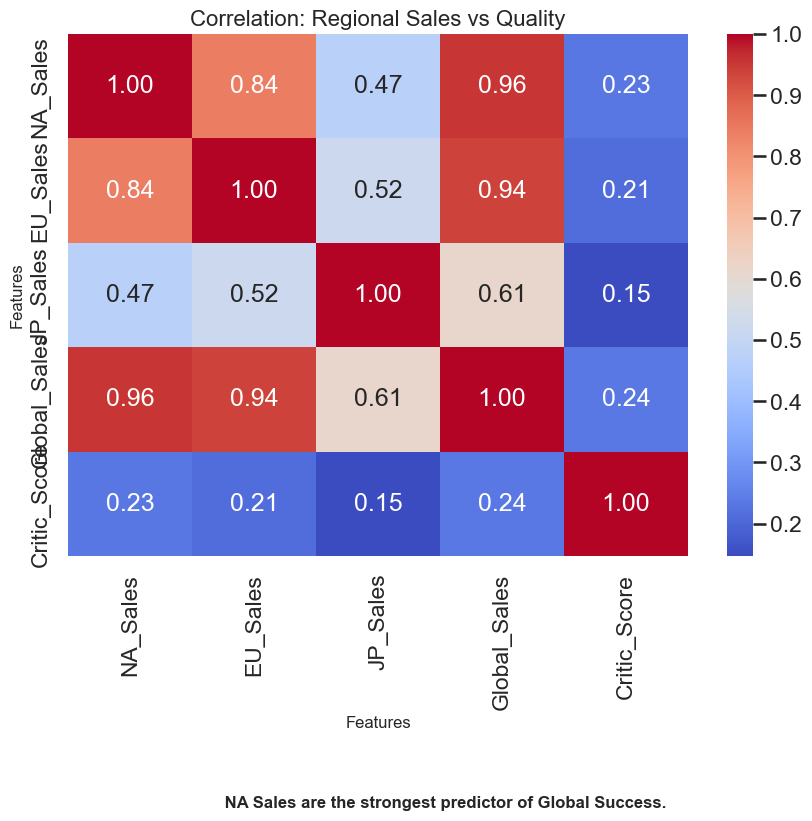

In [41]:
plt.figure(figsize=(10, 9))
cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales', 'Critic_Score']
sns.heatmap(df_scored[cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Correlation: Regional Sales vs Quality", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add Caption inside the image (Now Bold)
plt.figtext(0.5, 0.02, " NA Sales are the strongest predictor of Global Success.", 
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')
plt.subplots_adjust(bottom=0.3)
plt.show()

# Step 8: Conclusion

## 1. Summary of Findings

Genre Strategy: The data clearly identifies Action and Sports as the dominant genres. They generate the highest total revenue, making them the safest investment for publishers.

The "Hit" Economy: The industry is heavily skewed. A small number of blockbuster games (outliers) generate the majority of the profit, while the "average" game sees relatively low sales.

Quality vs. Sales: There is a proved positive relationship between Critic Scores and Global Sales. Better reviews generally lead to better financial performance.

##  2. Limitations & Future Improvements

Limitation (Missing Variables): Our prediction model had a low accuracy ($R^2$). This is because we lacked critical data like Marketing Budget and Brand Power (e.g., is it a Marvel or Mario game?). These factors often matter more than the review score.

Limitation (Old Data): This dataset stops around 2016. Trends may have shifted towards mobile gaming or microtransactions since then.

Improvement: Future analysis should include a "Marketing Spend" column and a "Sequel" flag (Yes/No) to build a much more accurate prediction model.

## 3. Key Takeaways

This project connected three distinct analytical layers. First, EDA revealed that the market is driven by specific genres (Action/Sports) and massive outliers. Second, our Statistical Inference (T-Test) validated that the difference in earnings between "Good" games (>80 score) and "Average" games is statistically significant, not random. Finally, our Linear Regression Model quantified this relationship, showing that while quality helps, it is not the sole predictor of success. Commercial hits are likely a combination of High Quality + High Marketing Investment.